In [1]:
import os

# Define the directory paths
training_dir = 'IRMAS-TrainingData/'
data = []

# Loop through each instrument directory
for instrument_dir in os.listdir(training_dir):
    instrument_path = os.path.join(training_dir, instrument_dir)
    
    # Check if it's a directory (i.e., an instrument folder)
    if os.path.isdir(instrument_path):
        for audio_file in os.listdir(instrument_path):
            if audio_file.endswith('.wav'):
                audio_path = os.path.join(instrument_path, audio_file)
                data.append({'audio_file': audio_path, 'label': instrument_dir})

# Show the organized data
print(data)


[{'audio_file': 'IRMAS-TrainingData/pia/[pia][cla]1346__3.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/[pia][cla]1291__1.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/[pia][jaz_blu]1490__3.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/027__[pia][nod][cla]1398__2.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/[pia][jaz_blu]1524__1.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/244__[pia][nod][cla]1384__1.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/[pia][cla]1370__2.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/[pia][jaz_blu]1459__1.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/057__[pia][nod][cla]1413__2.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/170__[pia][nod][cla]1403__2.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/[pia][pop_roc]1546__1.wav', 'label': 'pia'}, {'audio_file': 'IRMAS-TrainingData/pia/[pia][cla]1325__3.wav', 

In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Directory for training data
train_dir = 'IRMAS-TrainingData/'

# Initialize lists for data and labels
all_mfccs = []
all_labels = []

# Helper function to process audio files and extract MFCCs
def process_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_resized = np.resize(mfcc, (128, 128, 1))
    return mfcc_resized

# Load data from training directory where directories are named for labels
for root, dirs, files in os.walk(train_dir):
    for dir_name in dirs:
        label_dir_path = os.path.join(root, dir_name)
        
        for file in os.listdir(label_dir_path):
            if file.endswith('.wav'):
                audio_path = os.path.join(label_dir_path, file)
                
                # Process audio file and extract MFCCs
                mfcc_resized = process_audio_file(audio_path)
                all_mfccs.append(mfcc_resized)
                
                # Assign the directory name as the label for the audio file
                all_labels.append(dir_name)

# Convert lists to NumPy arrays
X = np.array(all_mfccs)

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(all_labels)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of training and testing data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (5364, 128, 128, 1)
Testing data shape: (1341, 128, 128, 1)


In [4]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential([
    layers.InputLayer(input_shape=(128, 128, 1)),  
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), steps_per_epoch = 50)


Epoch 1/100
50/50 [==============================] - 15s 301ms/step - loss: 68.8954 - accuracy: 0.1131 - val_loss: 2.3879 - val_accuracy: 0.1447
Epoch 2/100
50/50 [==============================] - 17s 339ms/step - loss: 2.3777 - accuracy: 0.1750 - val_loss: 2.3486 - val_accuracy: 0.1857
Epoch 3/100
50/50 [==============================] - 17s 343ms/step - loss: 2.2990 - accuracy: 0.1744 - val_loss: 2.2481 - val_accuracy: 0.1879
Epoch 4/100
50/50 [==============================] - 15s 307ms/step - loss: 2.1688 - accuracy: 0.2317 - val_loss: 2.0807 - val_accuracy: 0.2699
Epoch 5/100
50/50 [==============================] - 15s 311ms/step - loss: 1.9981 - accuracy: 0.3131 - val_loss: 2.0016 - val_accuracy: 0.3117
Epoch 6/100
50/50 [==============================] - 15s 308ms/step - loss: 2.0387 - accuracy: 0.2887 - val_loss: 1.9605 - val_accuracy: 0.3281
Epoch 7/100
50/50 [==============================] - 15s 309ms/step - loss: 1.9288 - accuracy: 0.3489 - val_loss: 1.9170 - val_accuracy

In [6]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions on the test data
predictions = model.predict(X_test)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Decode the predicted and true labels
predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)
true_labels_decoded = label_encoder.inverse_transform(y_test)

# Display some predictions and true labels
for i in range(20):
    print(f"Predicted: {predicted_labels_decoded[i]}, True: {true_labels_decoded[i]}")

42/42 [==============================] - 3s 74ms/step - loss: 5.0359 - accuracy: 0.3453
Test Accuracy: 34.53%
42/42 [==============================] - 3s 68ms/step
Predicted: voi, True: voi
Predicted: cel, True: gel
Predicted: pia, True: pia
Predicted: gel, True: gel
Predicted: org, True: org
Predicted: cla, True: cla
Predicted: flu, True: pia
Predicted: flu, True: tru
Predicted: sax, True: gac
Predicted: cla, True: pia
Predicted: flu, True: flu
Predicted: cla, True: cla
Predicted: cla, True: gel
Predicted: gel, True: gac
Predicted: sax, True: tru
Predicted: cla, True: cel
Predicted: tru, True: cla
Predicted: vio, True: vio
Predicted: pia, True: pia
Predicted: org, True: org


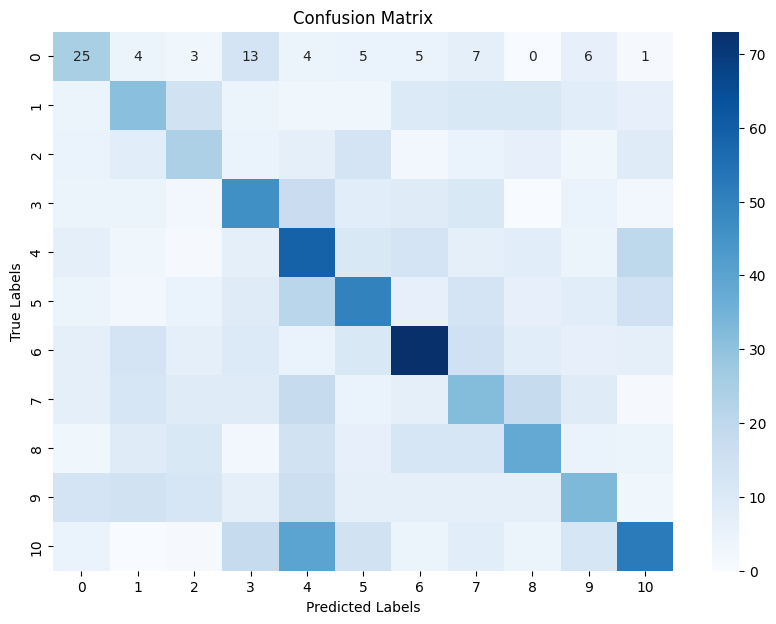

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(true_labels_decoded, predicted_labels_decoded)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#optimizer = tf.optimizer.SGD(learning_rate)


In [ ]:
f"def run_optimization(x,y):
    with tf.GradientTape() as g:
        pred = neural_net(x,is_training = True)
        loss = cross_entropy_loss(pred, y)

    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))"
    